importing packages:

In [4]:
# first importing libraries
import base64
import requests
import numpy as np
import gdown
from zipfile import ZipFile
import gzip as gzip
import os

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import pandas as pd
from torchvision.io import read_image
import re
import cv2
from skimage.transform import resize
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from torch.optim import lr_scheduler


from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

import time
import os
import copy

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [6]:
!pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git
import face_detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hukkelas/DSFD-Pytorch-Inference.git to /tmp/pip-req-build-ipo8933n
  Running command git clone --filter=blob:none --quiet https://github.com/hukkelas/DSFD-Pytorch-Inference.git /tmp/pip-req-build-ipo8933n
  Resolved https://github.com/hukkelas/DSFD-Pytorch-Inference.git to commit fc1051d80936e3d7a6e34053bb5485c0a032e42e
  Preparing metadata (setup.py) ... done
  Created wheel for face-detection: filename=face_detection-0.2.1-py3-none-any.whl size=29707 sha256=3554a414c1353ea521675a1032ba6b293d847233df804ba94c9e050d84a63e8e
  Stored in directory: /tmp/pip-ephem-wheel-cache-jm6p7fx_/wheels/57/d0/53/55657e0e64121cb64c10829c2f29bb3703afd0dcee55416e51
Successfully built face-detection


In [7]:
!git clone https://github.com/XL2248/MSCTD.git

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 11.58 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.


In [8]:
from google.colab import drive
drive.mount('/content/gdrive') # we use google drive to load files and save models there! so change path files based on your own data and run the code!

Mounted at /content/gdrive


Here we provide enough code snippets to form the input matrices for models used but we used the saved ones from previous phases:

In [9]:
!rm -r /content/gdrive/MyDrive/Phase_0_images

rm: cannot remove '/content/gdrive/MyDrive/Phase_0_images': No such file or directory


In [ ]:
def donwload_to_file(grdive_path,file_name,output_path):
  """
  function for downloading zip files from google drive and save it to desired path on colab

  inputs:
    grdive_path: path of file we want to download (url should be in export=download format)
    file_name: name of file we want to download
    output_path:path we extract data into
  outputs:
    we dont have any output!

  """
  gdown.download(grdive_path, file_name)
  with ZipFile(file_name, 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall(output_path)

In [ ]:
# for train          
donwload_to_file('https://drive.google.com/u/0/uc?id=1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj&export=download','train_ende.zip','/content/gdrive/MyDrive/Phase_0_images')
# renaming train folder name (it's train_ende) to just train so it is more consistent with other folders names
os.rename('/content/gdrive/MyDrive/Phase_0_images/train_ende','/content/gdrive/MyDrive/Phase_0_images/train')

# for validation     https://drive.google.com/u/0/uc?id=12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA&export=download
donwload_to_file('https://drive.google.com/u/0/uc?id=12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA&export=download','dev.zip','/content/gdrive/MyDrive/Phase_0_images')

# for test
donwload_to_file('https://drive.google.com/u/0/uc?id=1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W&export=download','test.zip','/content/gdrive/MyDrive/Phase_0_images')

In [ ]:
model_vgg_trained =torchvision.models.vgg16(pretrained=True)
for param in model_vgg_trained.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_vgg_trained.classifier[6] = nn.Linear(4096, 3) # we have 3 output class
model_vgg_trained = model_vgg_trained.to(device)
if device == 'cpu':
  model_vgg_trained.load_state_dict(torch.load('/content/gdrive/MyDrive/Phase_1_models/vgg_trained/gdrivemodel_vgg_trained_weights.pth',map_location=torch.device('cpu')))
else:
  model_vgg_trained.load_state_dict(torch.load('/content/gdrive/MyDrive/Phase_1_models/vgg_trained/gdrivemodel_vgg_trained_weights.pth'))
model_vgg_trained.eval()

In [ ]:
print(model_vgg_trained)

In [ ]:
model_resnet_trained= torchvision.models.resnet50(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet_trained.fc.in_features
model_resnet_trained.fc = nn.Linear(num_ftrs, 3) # we have 10 output class

model_resnet_trained= model_resnet_trained.to(device)
if device == 'cpu':
  model_resnet_trained.load_state_dict(torch.load('/content/gdrive/MyDrive/Phase_1_models/resnet_trained',map_location=torch.device('cpu')))
else:
  model_resnet_trained.load_state_dict(torch.load('/content/gdrive/MyDrive/Phase_1_models/resnet_trained'))
model_resnet_trained.eval()

In [10]:
class MSTCDDate(Dataset):
  """
  data loader class for getting data but one image (and it corresponding dialogue and label at a time)
  inputs:
    image_path: folder path of image data
    txt_path: folder path of txt data
    language: language type(english,german,...)
    mode: train,test,validation 
    image_format: jpg,png,...
    sclae: upscaling or downscaling image
    transform: transformation we want to apply on data
    target_transform: transformation we want to apply on labels



  """
   

  def __init__(self,image_path,txt_path,language,mode,image_format,scale, transform=None, target_transform=None):
     
      text_loader = language + '_' + mode + '.txt'
      sentiment_loader = 'sentiment_' + mode+'.txt'
      index_file = 'image_index_' + mode + '.txt'
      self.image_path = image_path
      self.transform = transform
      self.target_transform = target_transform
      self.mode = mode
      self.image_format = image_format
      self.scale = scale
      for file_names in os.scandir(txt_path):
        name_file = os.path.basename(file_names)
        if name_file == text_loader:
          with open(file_names.path) as f:
            self.text_file = [line.rstrip('\n') for line in f]
        if name_file == sentiment_loader:
          with open(file_names.path) as f:
            self.sentiment_file = [line.rstrip('\n') for line in f]
        if name_file == index_file:
          with open(file_names.path) as f:
            self.index_file = [line.rstrip('\n') for line in f]

  def __len__(self):
      return len(self.text_file)

  def __getitem__(self, idx):
      image_path_complete = self.image_path + '/' + self.mode + '/'
      text_file_chosen = self.text_file[idx]
      sentiment_chosen = int(self.sentiment_file[idx])
      temp_image = cv2.imread(image_path_complete+str(idx)+ '.' + self.image_format)
      n1,n2,n3 = np.shape(temp_image)
      if self.scale != 1:
        image = resize(temp_image,[int(n1/self.scale),int(n2/self.scale)], anti_aliasing=True)
      else:
        image = temp_image
      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          label = self.target_transform(sentiment_chosen)
      return  text_file_chosen,sentiment_chosen,image

In [ ]:
print(model_resnet_trained)

In [8]:
detector_mobilenet = face_detection.build_detector("RetinaNetMobileNetV1", confidence_threshold=.7, nms_iou_threshold=.3)

Downloading: "https://folk.ntnu.no/haakohu/RetinaFace_mobilenet025.pth" to /root/.cache/torch/hub/checkpoints/RetinaFace_mobilenet025.pth


  0%|          | 0.00/1.71M [00:00<?, ?B/s]

In [ ]:
data_train = MSTCDDate('/content/gdrive/MyDrive/Phase_0_images','/content/MSCTD/MSCTD_data/ende','english','train','jpg',1)
a=data_train

In [ ]:
data_val = MSTCDDate('/content/gdrive/MyDrive/Phase_0_images/dev','/content/MSCTD/MSCTD_data/ende','english','dev','jpg',1)

In [ ]:
data_test = MSTCDDate('/content/gdrive/MyDrive/Phase_0_images/test','/content/MSCTD/MSCTD_data/ende','english','test','jpg',1)

In [ ]:
transformation_resnet= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
transformation_vgg= transforms.Compose([transforms.ToTensor(),transforms.Resize((50,100)),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [ ]:
sentiment_list = []
inp=torch.zeros(len(data_train),7*3+1)
counter = 0
for i in tqdm(range(len(data_train)), total = len(data_train), desc="extracting faces... "):
  help=[]
  text_file_chosen,sentiment_chosen,image = data_train[i] # loading file
  imagep=image[:,:,[2,1,0]]
  image1=torch.unsqueeze(transformation_vgg(imagep),0)
  image1=image1.to(device)
  with torch.no_grad():
    image_out=model_vgg_trained(image1)
  #image2=torch.unsqueeze(transformation_resnet(image),0)
  #image2=image2.to(device)
  face_all = detector_mobilenet.detect(image)
  inp[i,0]=len(face_all)
  c=0
  for xmin,ymin,xmax,ymax,confidence in face_all:
    if c>=6:
      break;
    if xmin < 0 :
      xmin = 0
    if ymin < 0:
      ymin = 0
    sentiment_list.append(sentiment_chosen)
    temp = image[int(ymin): int(ymax),int(xmin):int(xmax),:]
    temp = resize(temp,[int(100),int(75)], anti_aliasing=True)
    temp = temp[:,:,[2,1,0]]
    temp = torch.unsqueeze(transformation_resnet(temp),0)
    temp = temp.float()
    temp=temp.to(device)
    with torch.no_grad():
      face=model_resnet_trained(temp)
    inp[i,c+1:c+4]=face
    c+=1
  inp[i,-4:-1]=image_out  
  counter = counter + 1

In [ ]:
import pickle
with open("/content/sample_data/inp", "wb") as fp:   #Pickling
  pickle.dump(inp, fp)
with open("/content/sample_data/sentiment_list", "wb") as fp:   #Pickling
  pickle.dump(sentiment_list, fp)


In [ ]:
#for validation
sentiment_list_v = []
inp_v=torch.zeros(len(data_val),7*3+1)
counter = 0
for i in tqdm(range(len(data_val)), total = len(data_val), desc="extracting faces... "):
  text_file_chosen,sentiment_chosen,image = data_val[i] # loading file
  imagep=image[:,:,[2,1,0]]
  image1=torch.unsqueeze(transformation_vgg(imagep),0)
  image1=image1.to(device)
  with torch.no_grad():
    image_out=model_vgg_trained(image1)
  #image2=torch.unsqueeze(transformation_resnet(image),0)
  #image2=image2.to(device)
  face_all = detector_mobilenet.detect(image)
  inp_v[i,0]=len(face_all)
  c=0
  for xmin,ymin,xmax,ymax,confidence in face_all:
    if c>=6:
      break;
    if xmin < 0 :
      xmin = 0
    if ymin < 0:
      ymin = 0
    sentiment_list_v.append(sentiment_chosen)
    temp = image[int(ymin): int(ymax),int(xmin):int(xmax),:]
    temp = resize(temp,[int(100),int(75)], anti_aliasing=True)
    temp = temp[:,:,[2,1,0]]
    temp = torch.unsqueeze(transformation_resnet(temp),0)
    temp = temp.float()
    temp=temp.to(device)
    with torch.no_grad():
      face=model_resnet_trained(temp)
    inp_v[i,c+1:c+4]=face
    c+=1
  inp_v[i,-4:-1]=image_out  
  counter = counter + 1

In [ ]:
import pickle
with open("/content/gdrive/MyDrive/inp_v", "wb") as fp:   #Pickling
  pickle.dump(inp_v, fp)
with open("/content/gdrive/MyDrive/sentiment_list_v", "wb") as fp:   #Pickling
  pickle.dump(sentiment_list_v, fp)

In [ ]:
# for test
sentiment_list_t = []
inp_t=torch.zeros(len(data_test),7*3+1)
counter = 0
for i in tqdm(range(len(data_test)), total = len(data_test), desc="extracting faces... "):
  text_file_chosen,sentiment_chosen,image = data_test[i] # loading file
  imagep=image[:,:,[2,1,0]]
  image1=torch.unsqueeze(transformation_vgg(imagep),0)
  image1=image1.to(device)
  with torch.no_grad():
    image_out=model_vgg_trained(image1)
  #image2=torch.unsqueeze(transformation_resnet(image),0)
  #image2=image2.to(device)
  face_all = detector_mobilenet.detect(image)
  inp_t[i,0]=len(face_all)
  c=0
  for xmin,ymin,xmax,ymax,confidence in face_all:
    if c>=6:
      break;
    if xmin < 0 :
      xmin = 0
    if ymin < 0:
      ymin = 0
    sentiment_list_t.append(sentiment_chosen)
    temp = image[int(ymin): int(ymax),int(xmin):int(xmax),:]
    temp = resize(temp,[int(100),int(75)], anti_aliasing=True)
    temp = temp[:,:,[2,1,0]]
    temp = torch.unsqueeze(transformation_resnet(temp),0)
    temp = temp.float()
    temp=temp.to(device)
    with torch.no_grad():
      face=model_resnet_trained(temp)
    inp_t[i,c+1:c+4]=face
    c+=1
  inp_t[i,-4:-1]=image_out  
  counter = counter + 1

In [ ]:
import pickle
with open("/content/gdrive/MyDrive/inp_t", "wb") as fp:   #Pickling
  pickle.dump(inp_t, fp)
with open("/content/gdrive/MyDrive/sentiment_list_t", "wb") as fp:   #Pickling
  pickle.dump(sentiment_list_t, fp)

Here are the code snippets to load the saved matrices. we use these data in the following:

In [170]:
with open('/content/MSCTD/MSCTD_data/ende/sentiment_train.txt') as f:
  sentiment_train = [int(line.rstrip('\n')) for line in f]
with open('/content/MSCTD/MSCTD_data/ende/sentiment_dev.txt') as f:
  sentiment_dev = [int(line.rstrip('\n')) for line in f]
with open('/content/MSCTD/MSCTD_data/ende/sentiment_test.txt') as f:
  sentiment_test = [int(line.rstrip('\n')) for line in f]

In [155]:
import pickle
with open("/content/gdrive/MyDrive/phase3/train1/sentiment_list", "rb") as fp:   #Pickling
  sentiment_list =  pickle.load(fp)
with open("/content/gdrive/MyDrive/phase3/train1/inp", "rb") as fp:   #Pickling
  inp = pickle.load(fp)

In [156]:
with open("/content/gdrive/MyDrive/phase3/dev1/sentiment_list_v", "rb") as fp:   #Pickling
  sentiment_list_v =  pickle.load(fp)
with open("/content/gdrive/MyDrive/phase3/dev1/inp_v", "rb") as fp:   #Pickling
  inp_v = pickle.load(fp)

In [157]:
with open("/content/gdrive/MyDrive/phase3/test1/sentiment_list_t", "rb") as fp:   #Pickling
  sentiment_list_t =  pickle.load(fp)
with open("/content/gdrive/MyDrive/phase3/test1/inp_t", "rb") as fp:   #Pickling
  inp_t = pickle.load(fp)

In [158]:
class comb_Dataset(Dataset):
    def __init__(self,inp,labels):
        self.inp = inp
        self.lables = labels

    def __len__(self):
        return len(self.lables)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        inp = self.inp[idx]
        lables = self.lables[idx]
        return inp,lables

here we provide two different datasets and data loader. the one with -i in the end refers to the matices which contains only the faces features. the other one contains both the image and faces features

In [171]:
batch_size = 64
train_dataset= comb_Dataset(inp=inp,labels=sentiment_train)
train_loader= DataLoader(train_dataset,batch_size=batch_size,shuffle = True)



In [172]:
batch_size = 64
train_dataset_i= comb_Dataset(inp=inp[:,:-3],labels=sentiment_train)
train_loader_i= DataLoader(train_dataset_i,batch_size=batch_size,shuffle = True)


In [173]:
val_dataset = comb_Dataset(inp=inp_v,  labels=sentiment_dev)
val_loader=   DataLoader(val_dataset,batch_size=batch_size,shuffle = False)

In [174]:
val_dataset_i = comb_Dataset(inp=inp_v[:,:-3],  labels=sentiment_dev)
val_loader_i=   DataLoader(val_dataset_i,batch_size=batch_size,shuffle = False)

In [175]:
test_dataset = comb_Dataset(inp=inp_t,  labels=sentiment_test)
test_loader= DataLoader(test_dataset,batch_size=64,shuffle = False)

In [176]:
test_dataset_i = comb_Dataset(inp=inp_t[:,:-3],  labels=sentiment_test)
test_loader_i= DataLoader(test_dataset_i,batch_size=64,shuffle = False)

here we form a MLP to classify data with both the image and faces features:

In [165]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layers=nn.Sequential(
        nn.Linear(3*(6+1)+1,64),
        nn.ReLU(),
        nn.Linear(64,16),
        nn.ReLU(),
        nn.Linear(16,32),
        nn.ReLU(),
        nn.Linear(32,8),
        nn.ReLU(),
        nn.Linear(8,64),
        nn.ReLU(),
        nn.Linear(64,16),
        nn.ReLU(),
        nn.Linear(16,32),
        nn.ReLU(),
        nn.Linear(32,8),
        nn.ReLU(),
        nn.Linear(8,64),
        nn.ReLU(),
        nn.Linear(64,16),
        nn.ReLU(),
        nn.Linear(16,32),
        nn.ReLU(),
        nn.Linear(32,8),
        nn.ReLU(),
        nn.Linear(8,3)
        )
  def forward(self, x):
    return self.layers(x)


net = Net()

In [166]:
net= net.to(device)
if device == 'cpu':
  net.load_state_dict(torch.load('/content/gdrive/MyDrive/phase3/comb_trained',map_location=torch.device('cpu')))
else:
  net.load_state_dict(torch.load('/content/gdrive/MyDrive/phase3/comb_trained'))
net.eval()

Net(
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=16, bias=True)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=8, bias=True)
    (15): ReLU()
    (16): Linear(in_features=8, out_features=64, bias=True)
    (17): ReLU()
    (18): Linear(in_features=64, out_features=16, bias=True)
    (19): ReLU()
    (20): Linear(in_features=16, out_features=32, bias=True)
    (21): ReLU()
    (22): Linear(in_features=32, out_features=8, bias=True)
    (23): ReLU()
    (24): Linear(in_features=8, out_features=3, bi

net1 forms a MLP model for only the faces' features

In [180]:
import torch.nn as nn
import torch.nn.functional as F


class Net1(nn.Module):
  def __init__(self):
    super(Net1, self).__init__()
    self.layers=nn.Sequential(
        nn.Linear(3*(6)+1,64),
        nn.ReLU(),
        nn.Linear(64,16),
        nn.ReLU(),
        nn.Linear(16,32),
        nn.ReLU(),
        nn.Linear(32,8),
        nn.ReLU(),
        nn.Linear(8,64),
        nn.ReLU(),
        nn.Linear(64,16),
        nn.ReLU(),
        nn.Linear(16,32),
        nn.ReLU(),
        nn.Linear(32,8),
        nn.ReLU(),
        nn.Linear(8,64),
        nn.ReLU(),
        nn.Linear(64,16),
        nn.ReLU(),
        nn.Linear(16,32),
        nn.ReLU(),
        nn.Linear(32,8),
        nn.ReLU(),
        nn.Linear(8,3)
        )
  def forward(self, x):
    return self.layers(x)


net1 = Net1()

this is the train loop

In [168]:
def train_model_manual(model, criterion, optimizer,scheduler,val_beark,data_loader_train,data_loader_val,len_train,len_val, num_epochs=25):

  train_acc = []
  train_loss = []
  test_acc = []
  test_loss = []
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 100000000000
  counter_val_beark = 0
  for epoch in range(num_epochs):
    ### Training
    model.train()
    loss_train = 0
    acc_train = 0
    counter = 1
    for batch,label in tqdm(data_loader_train, total=len(data_loader_train), desc="training... "):
      # 1. Forward pass
      batch = batch.to(device)
      label = label.to(device)
      outputs = model(batch) # model outputs raw logits 
      _, preds = torch.max(outputs, 1)

      # print(y_logits)
      # 2. Calculate loss and accuracy
      counter = counter + 1
      loss = criterion(outputs, label)
      acc_train += torch.sum(preds == label.data)
      loss_train = loss_train + loss
      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()
    loss_train = loss_train/20240*100
    acc_train = acc_train/20240*100
    train_acc.append(acc_train)
    train_loss.append(loss_train)
    scheduler.step()
    ### Testing
    loss_test = 0
    acc_test = 0
    counter = 1
    model.eval()
    with torch.inference_mode():
      for batch,label in tqdm(data_loader_val, total=len(data_loader_val), desc="Validating... "):
      # 1. Forward pass
        batch = batch.to(device)
        label = label.to(device)
        output = model(batch) # model outputs raw logits 
        _, preds = torch.max(output, 1)
        loss_test= criterion(output, label.data)
        acc_test += torch.sum(preds == label.data)
      loss_test = loss_test/5063*100
      acc_test = acc_test/5063*100
      test_loss.append(loss_test)
      test_acc.append(acc_test)
    if acc_test > best_acc:
                best_acc = acc_test
                best_model_wts = copy.deepcopy(model.state_dict())
    if loss_test <= best_loss:
                best_loss = loss_test
                counter_val_beark = 0
    if loss_test > best_loss:
                counter_val_beark = counter_val_beark + 1
                if (counter_val_beark > val_beark):
                  print(f"early stopping happend!")
                  break;

    # Print out what's happening
    if epoch % 1 == 0:
      print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test Loss: {loss_test:.5f}, Test Acc: {acc_test:.2f}%") 
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model,best_loss,best_acc

here we train the net model which classifies both the image and the faces data

In [177]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer= optim.Adam(net.parameters(), lr=0.001)
# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

net = net.to(device)
model_comb_trained,best_loss,best_acc = train_model_manual(net, criterion, optimizer,exp_lr_scheduler,20,train_loader,val_loader,len(train_loader),len(val_loader),num_epochs=100)

Validating... : 100%|██████████| 80/80 [00:00<00:00, 582.17it/s]


Epoch: 0 | Loss: 1.69799, Acc: 39.97% | Test Loss: 0.02078, Test Acc: 37.51%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 901.63it/s]


Epoch: 1 | Loss: 1.69694, Acc: 39.92% | Test Loss: 0.02050, Test Acc: 37.21%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 945.16it/s]


Epoch: 2 | Loss: 1.69681, Acc: 40.29% | Test Loss: 0.02054, Test Acc: 37.27%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 964.86it/s]


Epoch: 3 | Loss: 1.69603, Acc: 40.05% | Test Loss: 0.02077, Test Acc: 37.80%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 919.62it/s]


Epoch: 4 | Loss: 1.69655, Acc: 40.18% | Test Loss: 0.02076, Test Acc: 37.19%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 888.20it/s]


Epoch: 5 | Loss: 1.69574, Acc: 40.42% | Test Loss: 0.02096, Test Acc: 37.69%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 684.71it/s]


Epoch: 6 | Loss: 1.69615, Acc: 40.36% | Test Loss: 0.02059, Test Acc: 37.29%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 576.07it/s]


Epoch: 7 | Loss: 1.69511, Acc: 40.48% | Test Loss: 0.02121, Test Acc: 37.78%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 959.24it/s]


Epoch: 8 | Loss: 1.69483, Acc: 40.42% | Test Loss: 0.02097, Test Acc: 37.05%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 909.82it/s]


Epoch: 9 | Loss: 1.69728, Acc: 40.25% | Test Loss: 0.02116, Test Acc: 37.37%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 988.45it/s]


Epoch: 10 | Loss: 1.69464, Acc: 40.61% | Test Loss: 0.02113, Test Acc: 37.88%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 959.37it/s]


Epoch: 11 | Loss: 1.69467, Acc: 40.81% | Test Loss: 0.02109, Test Acc: 37.94%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 997.86it/s]


Epoch: 12 | Loss: 1.69424, Acc: 40.69% | Test Loss: 0.02098, Test Acc: 37.45%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 675.65it/s]


Epoch: 13 | Loss: 1.69423, Acc: 40.58% | Test Loss: 0.02096, Test Acc: 37.53%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 643.84it/s]


Epoch: 14 | Loss: 1.69382, Acc: 40.72% | Test Loss: 0.02099, Test Acc: 37.45%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1020.06it/s]


Epoch: 15 | Loss: 1.69394, Acc: 40.69% | Test Loss: 0.02100, Test Acc: 37.39%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1008.75it/s]


Epoch: 16 | Loss: 1.69370, Acc: 40.70% | Test Loss: 0.02105, Test Acc: 37.82%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 975.30it/s]


Epoch: 17 | Loss: 1.69382, Acc: 40.69% | Test Loss: 0.02102, Test Acc: 37.43%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 869.39it/s]


Epoch: 18 | Loss: 1.69339, Acc: 40.74% | Test Loss: 0.02104, Test Acc: 37.39%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 921.73it/s]


Epoch: 19 | Loss: 1.69353, Acc: 40.79% | Test Loss: 0.02107, Test Acc: 37.86%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 635.50it/s]


Epoch: 20 | Loss: 1.69338, Acc: 40.81% | Test Loss: 0.02107, Test Acc: 37.88%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1019.12it/s]


Epoch: 21 | Loss: 1.69307, Acc: 40.76% | Test Loss: 0.02106, Test Acc: 37.84%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 907.43it/s]


early stopping happend!
Training complete in 0m 52s
Best val Acc: 37.941933


here we train the net1 model which contains faces' features:

In [181]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer= optim.Adam(net1.parameters(), lr=0.001)
# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

net1 = net1.to(device)
model_face_trained,best_loss,best_acc = train_model_manual(net1, criterion, optimizer,exp_lr_scheduler,20,train_loader_i,val_loader_i,len(train_loader_i),len(val_loader_i),num_epochs=100)

Validating... : 100%|██████████| 80/80 [00:00<00:00, 563.23it/s]


Epoch: 0 | Loss: 1.70638, Acc: 38.11% | Test Loss: 0.02173, Test Acc: 36.30%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 543.56it/s]


Epoch: 1 | Loss: 1.70219, Acc: 38.73% | Test Loss: 0.02187, Test Acc: 36.11%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 612.74it/s]


Epoch: 2 | Loss: 1.70131, Acc: 38.69% | Test Loss: 0.02074, Test Acc: 36.28%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 897.96it/s]


Epoch: 3 | Loss: 1.70059, Acc: 39.39% | Test Loss: 0.02102, Test Acc: 37.31%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 617.79it/s]


Epoch: 4 | Loss: 1.69946, Acc: 39.93% | Test Loss: 0.02126, Test Acc: 37.35%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 570.66it/s]


Epoch: 5 | Loss: 1.69919, Acc: 40.08% | Test Loss: 0.02001, Test Acc: 37.15%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 888.59it/s]


Epoch: 6 | Loss: 1.69980, Acc: 39.92% | Test Loss: 0.02129, Test Acc: 37.39%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 972.88it/s]


Epoch: 7 | Loss: 1.69939, Acc: 40.00% | Test Loss: 0.02092, Test Acc: 37.23%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 990.47it/s]


Epoch: 8 | Loss: 1.69909, Acc: 40.05% | Test Loss: 0.02051, Test Acc: 37.35%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 928.78it/s]


Epoch: 9 | Loss: 1.69897, Acc: 40.19% | Test Loss: 0.02007, Test Acc: 37.39%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 971.56it/s]


Epoch: 10 | Loss: 1.69919, Acc: 40.16% | Test Loss: 0.02060, Test Acc: 37.31%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 639.89it/s]


Epoch: 11 | Loss: 1.69880, Acc: 40.16% | Test Loss: 0.02102, Test Acc: 37.49%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 567.70it/s]


Epoch: 12 | Loss: 1.69887, Acc: 40.14% | Test Loss: 0.02076, Test Acc: 37.49%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 912.06it/s]


Epoch: 13 | Loss: 1.69836, Acc: 40.11% | Test Loss: 0.02019, Test Acc: 37.19%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 937.53it/s]


Epoch: 14 | Loss: 1.69823, Acc: 40.17% | Test Loss: 0.02052, Test Acc: 37.21%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 974.77it/s]


Epoch: 15 | Loss: 1.69844, Acc: 40.01% | Test Loss: 0.01992, Test Acc: 36.44%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 931.41it/s]


Epoch: 16 | Loss: 1.69861, Acc: 40.11% | Test Loss: 0.02072, Test Acc: 36.90%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 929.77it/s]


Epoch: 17 | Loss: 1.69778, Acc: 40.18% | Test Loss: 0.02139, Test Acc: 37.07%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 603.53it/s]


Epoch: 18 | Loss: 1.69814, Acc: 40.23% | Test Loss: 0.02075, Test Acc: 36.97%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 745.18it/s]


Epoch: 19 | Loss: 1.69772, Acc: 40.31% | Test Loss: 0.02123, Test Acc: 36.93%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 967.95it/s]


Epoch: 20 | Loss: 1.69823, Acc: 40.23% | Test Loss: 0.02080, Test Acc: 36.93%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 957.11it/s]


Epoch: 21 | Loss: 1.69799, Acc: 40.13% | Test Loss: 0.02040, Test Acc: 37.25%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 961.15it/s]


Epoch: 22 | Loss: 1.69719, Acc: 40.14% | Test Loss: 0.02037, Test Acc: 37.11%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 939.64it/s]


Epoch: 23 | Loss: 1.69817, Acc: 40.33% | Test Loss: 0.02103, Test Acc: 37.45%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 627.12it/s]


Epoch: 24 | Loss: 1.69790, Acc: 40.13% | Test Loss: 0.02096, Test Acc: 37.23%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 686.01it/s]


Epoch: 25 | Loss: 1.69703, Acc: 40.32% | Test Loss: 0.02033, Test Acc: 36.68%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 988.86it/s]


Epoch: 26 | Loss: 1.69715, Acc: 40.35% | Test Loss: 0.02101, Test Acc: 37.11%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 912.07it/s]


Epoch: 27 | Loss: 1.69669, Acc: 40.46% | Test Loss: 0.02123, Test Acc: 36.84%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 971.85it/s]


Epoch: 28 | Loss: 1.69693, Acc: 40.48% | Test Loss: 0.02075, Test Acc: 37.13%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 970.10it/s]


Epoch: 29 | Loss: 1.69699, Acc: 40.21% | Test Loss: 0.02127, Test Acc: 37.21%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 976.85it/s]


Epoch: 30 | Loss: 1.69709, Acc: 40.22% | Test Loss: 0.02054, Test Acc: 37.09%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 665.44it/s]


Epoch: 31 | Loss: 1.69694, Acc: 40.22% | Test Loss: 0.02017, Test Acc: 36.32%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 631.98it/s]


Epoch: 32 | Loss: 1.69655, Acc: 40.40% | Test Loss: 0.02122, Test Acc: 37.43%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 961.75it/s]


Epoch: 33 | Loss: 1.69670, Acc: 40.44% | Test Loss: 0.02118, Test Acc: 37.17%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 989.19it/s]


Epoch: 34 | Loss: 1.69633, Acc: 40.37% | Test Loss: 0.02043, Test Acc: 36.90%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1008.38it/s]


Epoch: 35 | Loss: 1.69680, Acc: 40.45% | Test Loss: 0.02121, Test Acc: 36.56%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 967.24it/s]


early stopping happend!
Training complete in 1m 29s
Best val Acc: 37.487656


now we evaluate the models: first we do the train data:

first: image+faces:

In [183]:
model_comb_trained.eval()
acc_test = 0
prob_train_comb=torch.tensor([]).to(device)
label_train_comb=torch.tensor([]).to(device)
with torch.inference_mode():
  for batch,label in tqdm(train_loader, total=len(train_loader), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_comb_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    prob_train_comb=torch.cat((prob_train_comb,preds))
    label_train_comb=torch.cat((label_train_comb,label))
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on train data = {acc_test/len(train_dataset)}')

Testing... : 100%|██████████| 317/317 [00:02<00:00, 145.39it/s]



accuracy on train data = 0.4068181812763214


second:faces

In [185]:
model_face_trained.eval()
acc_test = 0
prob_train=torch.tensor([]).to(device)
label_train=torch.tensor([]).to(device)
with torch.inference_mode():
  for batch,label in tqdm(train_loader_i, total=len(train_loader_i), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_face_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    prob_train=torch.cat((prob_train,preds))
    label_train=torch.cat((label_train,preds))
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on train data = {acc_test/len(train_dataset)}')

Testing... : 100%|██████████| 317/317 [00:00<00:00, 326.83it/s]



accuracy on train data = 0.40271738171577454


now we do the same for validation:

first:image+faces:

In [ ]:
model_comb_trained.eval()
acc_test = 0
prob_val=torch.tensor([]).to(device)
label_val=torch.tensor([]).to(device)
with torch.inference_mode():
  for batch,label in tqdm(val_loader, total=len(val_loader), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_comb_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    prob_val=torch.cat((prob_val,preds))
    label_val=torch.cat((label_val,preds))
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on val data = {acc_test/len(val_dataset)}')

Testing... : 100%|██████████| 80/80 [00:00<00:00, 1010.47it/s]



accuracy on test data = 0.3798143267631531


second:face

In [190]:
model_face_trained.eval()
acc_test = 0
prob_val=torch.tensor([]).to(device)
label_val=torch.tensor([]).to(device)
with torch.inference_mode():
  for batch,label in tqdm(val_loader_i, total=len(val_loader_i), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_face_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    prob_val=torch.cat((prob_val,preds))
    label_val=torch.cat((label_val,preds))
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on val data = {acc_test/len(val_dataset)}')

Testing... : 100%|██████████| 80/80 [00:00<00:00, 285.07it/s]



accuracy on val data = 0.37487655878067017


now we do it on test data:

first: image+faces:

In [188]:
model_comb_trained.eval()
acc_test = 0
prob_test=torch.tensor([]).to(device)
label_test=torch.tensor([]).to(device)
with torch.inference_mode():
  for batch,label in tqdm(test_loader, total=len(test_loader), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_comb_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    prob_test=torch.cat((prob_test,preds))
    label_test=torch.cat((label_test,preds))
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on test data = {acc_test/len(test_dataset)}')

Testing... : 100%|██████████| 80/80 [00:00<00:00, 933.15it/s]



accuracy on test data = 0.39609235525131226


second: faces:

In [187]:
model_face_trained.eval()
acc_test = 0
prob_test=torch.tensor([]).to(device)
label_test=torch.tensor([]).to(device)
with torch.inference_mode():
  for batch,label in tqdm(test_loader_i, total=len(test_loader_i), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_face_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    prob_test=torch.cat((prob_test,preds))
    label_test=torch.cat((label_test,preds))
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on test data = {acc_test/len(test_dataset)}')

Testing... : 100%|██████████| 80/80 [00:00<00:00, 551.94it/s]



accuracy on test data = 0.4016183018684387


now we try to the classification using SVM.

first we try to traain the model on the train data

first: image + faces:

In [205]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
rbf = svm.SVC(kernel='rbf', gamma=0.9, C=50).fit(inp,sentiment_train)
svm_pred_train= rbf.predict(inp)
acc = np.sum(svm_pred_train == sentiment_train)/len(svm_pred_train)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.47959486166007903


second : faces

In [206]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
rbf_i = svm.SVC(kernel='rbf', gamma=0.9, C=50).fit(inp[:,:-3],sentiment_train)
svm_pred_train_i= rbf_i.predict(inp[:,:-3])
acc = np.sum(svm_pred_train_i == sentiment_train)/len(svm_pred_train_i)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.42208498023715413


now we do it on validation data:

first: image+faces

In [207]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#rbf = svm.SVC(kernel='rbf', gamma=0.5, C=10).fit(inp,sentiment_train)
svm_pred_val= rbf.predict(inp_v)
acc = np.sum(svm_pred_val == sentiment_dev)/len(svm_pred_val)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.3580880900651787


second: faces

In [208]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#rbf = svm.SVC(kernel='rbf', gamma=0.5, C=10).fit(inp_v[:,:-3],sentiment_train)
svm_pred_val_i= rbf_i.predict(inp_v[:,:-3])
acc = np.sum(svm_pred_val_i == sentiment_dev)/len(svm_pred_val_i)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.3614457831325301


now we do it on test data:

first: image+faces

In [209]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#rbf = svm.SVC(kernel='rbf', gamma=0.5, C=10).fit(inp,sentiment_train)
svm_pred_test= rbf.predict(inp_t)
acc = np.sum(svm_pred_test == sentiment_test)/len(svm_pred_test)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.4043812907045589


second: faces

In [210]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#rbf = svm.SVC(kernel='rbf', gamma=0.5, C=10).fit(inp[:,:-3],sentiment_train)
svm_pred_test_i= rbf_i.predict(inp_t[:,:-3])
acc = np.sum(svm_pred_test_i == sentiment_test)/len(svm_pred_test)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.40813104401026246


As it apears, different approaches have rather similar results. Therefore, as we have saved the MLP model with image and faces' features, we use that as of now. 

now we try to load the Lnguage model. first we use the GLOVE  implementation. like before, we provide enough code snippets to form the data, but we used the previously saved matrices.

now wwe import packeges:

In [20]:
# first importing libraries
import base64
import requests
import numpy as np
import gdown
from zipfile import ZipFile
import os

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import pandas as pd
from torchvision.io import read_image
import re
import cv2
from skimage.transform import resize
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from torch.optim import lr_scheduler


from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

import time
import os
import copy
import string

from nltk.corpus import stopwords
import nltk
import itertools
nltk.download('stopwords')
import nltk 
nltk.download('stopwords')
nltk.download ('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [213]:
!git clone https://github.com/XL2248/MSCTD.git

fatal: destination path 'MSCTD' already exists and is not an empty directory.


here we load the text data: 

In [214]:
with open('/content/MSCTD/MSCTD_data/ende/english_train.txt') as f:
    text_file_train = [line.rstrip('\n') for line in f]

In [215]:
with open('/content/MSCTD/MSCTD_data/ende/english_dev.txt') as f:
    text_file_dev = [line.rstrip('\n') for line in f]

In [216]:
with open('/content/MSCTD/MSCTD_data/ende/english_test.txt') as f:
    text_file_test = [line.rstrip('\n') for line in f]

now we remove punctuations, and stopwords; and apply lemmatization 

In [217]:
print(f'all possible punctuations = {string.punctuation}')
punc_remove = string.punctuation

all possible punctuations = !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [218]:
remove_translate = str.maketrans('', '', string.punctuation)

In [219]:
all_stopwords= stopwords.words('english')
chosen_stopword=[value for value in all_stopwords if value not in ["no","nor","not"]]
print(chosen_stopword)
print("no"in chosen_stopword)
print("nor"in chosen_stopword)
print("not"in chosen_stopword)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', '

In [220]:
print(text_file_dev[0])
print(text_file_train[0])
print(text_file_test[0])

He diagnosed Andy with growing pains.
Okay. I'm confused.
With this asshole?


In [221]:
lemmatizer=WordNetLemmatizer()

train:

In [222]:
all_txt_train_lem = []
for txt in text_file_train:
  txt = txt.translate(remove_translate)
  txt = txt.lower()
  txt = txt.split()
  filtered_words = [word for word in txt if word not in stopwords.words('english')]
  text_final = ""
  lem_line=[] 
  for word in filtered_words:
    lem_line.append(lemmatizer.lemmatize(word)) 
  for i in range(len(lem_line)):
    text_final = text_final + lem_line[i] + " "
  text_final = text_final[:-1]
  all_txt_train_lem.append(text_final)

validation:

In [223]:
all_txt_dev_lem = []
for txt in text_file_dev:
  txt = txt.translate(remove_translate)
  txt = txt.lower()
  txt = txt.split()
  filtered_words = [word for word in txt if word not in stopwords.words('english')]
  text_final = ""
  lem_line=[] 
  for word in filtered_words:
    lem_line.append(lemmatizer.lemmatize(word)) 
  for i in range(len(lem_line)):
    text_final = text_final + lem_line[i] + " "
  text_final = text_final[:-1]
  all_txt_dev_lem.append(text_final)

test:

In [224]:
all_txt_test_lem = []
for txt in text_file_test:
  txt = txt.translate(remove_translate)
  txt = txt.lower()
  txt = txt.split()
  filtered_words = [word for word in txt if word not in stopwords.words('english')]
  text_final = ""
  lem_line=[] 
  for word in filtered_words:
    lem_line.append(lemmatizer.lemmatize(word)) 
  for i in range(len(lem_line)):
    text_final = text_final + lem_line[i] + " "
  text_final = text_final[:-1]
  all_txt_test_lem.append(text_final)

In [225]:
from itertools import chain
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

now we tokenize"

In [226]:

for i in range(len(all_txt_train_lem)):
  all_txt_train_lem[i] =  '<shr> ' + "".join(all_txt_train_lem[i]) + ' <pia>'


tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(all_txt_train_lem)




vocab_size = len(tokenizer.word_index)+1
print(f"number of unique word in our created vocabulary = {vocab_size}")
print(tokenizer.word_index)






tokenized_txt_train_lem = []
MAXLEN = -1
for i in range(len(all_txt_train_lem)):
  tokenized = tokenizer.texts_to_sequences(all_txt_train_lem[i].split())
  tokenized = list(chain.from_iterable(tokenized))
  tokenized = np.asarray(tokenized)
  if (len(tokenized) > MAXLEN):
    MAXLEN = len(tokenized)
  tokenized_txt_train_lem.append(tokenized)
print(f"Max length of each line = {MAXLEN}")
print(f"first sample = {tokenized_txt_train_lem[0]}")





number of unique word in our created vocabulary = 9154
{'<oov>': 1, 'shr': 2, 'pia': 3, 'im': 4, 'know': 5, 'dont': 6, 'get': 7, 'like': 8, 'oh': 9, 'right': 10, 'well': 11, 'youre': 12, 'okay': 13, 'yeah': 14, 'go': 15, 'one': 16, 'got': 17, 'think': 18, 'thats': 19, 'gonna': 20, 'want': 21, 'need': 22, 'come': 23, 'look': 24, 'let': 25, 'going': 26, 'see': 27, 'good': 28, 'time': 29, 'back': 30, 'mean': 31, 'thing': 32, 'hey': 33, 'guy': 34, 'really': 35, 'say': 36, 'he': 37, 'cant': 38, 'u': 39, 'man': 40, 'take': 41, 'make': 42, 'didnt': 43, 'sorry': 44, 'something': 45, 'tell': 46, 'would': 47, 'little': 48, 'ill': 49, 'could': 50, 'way': 51, 'there': 52, 'day': 53, 'uh': 54, 'yes': 55, 'shes': 56, 'two': 57, 'ive': 58, 'never': 59, 'give': 60, 'whats': 61, 'wait': 62, 'said': 63, 'thought': 64, 'please': 65, 'much': 66, 'put': 67, 'people': 68, 'even': 69, 'love': 70, 'life': 71, 'still': 72, 'maybe': 73, 'help': 74, 'god': 75, 'year': 76, 'talk': 77, 'work': 78, 'anything': 79, 

In [227]:
for i in range(len(all_txt_dev_lem)):
  all_txt_dev_lem[i] =  '<shr> ' + "".join(all_txt_dev_lem[i]) + ' <pia>'

tokenized_txt_dev_lem= []
for i in range(len(all_txt_dev_lem)):
  tokenized = tokenizer.texts_to_sequences(all_txt_dev_lem[i].split())
  tokenized = list(chain.from_iterable(tokenized))
  tokenized = np.asarray(tokenized)
  if (len(tokenized) > MAXLEN):
    MAXLEN = len(tokenized)
  tokenized_txt_dev_lem.append(tokenized)
print(f"Max length of each line = {MAXLEN}")
print(f"first sample = {tokenized_txt_dev_lem[0]}")

Max length of each line = 13
first sample = [   2 4267 2944 1607  558    3]


In [228]:
for i in range(len(all_txt_test_lem)):
  all_txt_test_lem[i] =  '<shr> ' + "".join(all_txt_test_lem[i]) + ' <pia>'

tokenized_txt_test_lem = []
MAXLEN = -1
for i in range(len(all_txt_test_lem)):
  tokenized = tokenizer.texts_to_sequences(all_txt_test_lem[i].split())
  tokenized = list(chain.from_iterable(tokenized))
  tokenized = np.asarray(tokenized)
  if (len(tokenized) > MAXLEN):
    MAXLEN = len(tokenized)
  tokenized_txt_test_lem.append(tokenized)
print(f"Max length of each line = {MAXLEN}")
print(f"first sample = {tokenized_txt_test_lem[0]}")

Max length of each line = 12
first sample = [  2 560   3]


In [229]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/gdrive/MyDrive/glove/glove.6B.50d.txt')
for line in f:
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [230]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in tokenizer.word_index.items():
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
   embedding_matrix[i] = embedding_vector

In [231]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

In [232]:
e = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False)

here we pad the data:

In [233]:
padded_all_train= pad_sequences(list(tokenized_txt_train_lem), maxlen=MAXLEN, padding="post")
padded_all_dev = pad_sequences(list(tokenized_txt_dev_lem), maxlen=MAXLEN, padding="post")
padded_all_test = pad_sequences(list(tokenized_txt_test_lem), maxlen=MAXLEN, padding="post")

here we load the labels:

In [234]:
# loading sentiments
with open('/content/MSCTD/MSCTD_data/ende/sentiment_train.txt') as f:
  sentiment_train = [int(line.rstrip('\n')) for line in f]
with open('/content/MSCTD/MSCTD_data/ende/sentiment_dev.txt') as f:
  sentiment_dev = [int(line.rstrip('\n')) for line in f]
with open('/content/MSCTD/MSCTD_data/ende/sentiment_test.txt') as f:
  sentiment_test = [int(line.rstrip('\n')) for line in f]

In [235]:
import tensorflow as tf
sentiment_train_1hot= tf.convert_to_tensor(tf.keras.utils.to_categorical(np.asarray(sentiment_train)))
sentiment_dev_1hot = tf.convert_to_tensor(tf.keras.utils.to_categorical(np.asarray(sentiment_dev)))

In [236]:
sentiment_train_1hot[1]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>

here we form the processed train, validation and test data and save them:

In [237]:
array_train = np.asarray(padded_all_train)
array_dev = np.asarray(padded_all_dev)

In [238]:
array_test = np.asarray(padded_all_test)

In [239]:
import pickle
with open("/content/gdrive/MyDrive/phase3/traintext/train", "wb") as fp:   #Pickling
  pickle.dump(array_train, fp)
with open("/content/gdrive/MyDrive/phase3/devtext/dev", "wb") as fp:   #Pickling
  pickle.dump(array_dev, fp)
with open("/content/gdrive/MyDrive/phase3/testtext/test", "wb") as fp:   #Pickling
  pickle.dump(array_test, fp)

here we load the saved data. we use these datas as of now:

In [240]:
with open("/content/gdrive/MyDrive/phase3/traintext/train", "rb") as fp:   #Pickling
  array_train =  pickle.load(fp)
with open("/content/gdrive/MyDrive/phase3/devtext/dev", "rb") as fp:   #Pickling
  array_dev = pickle.load(fp)
with open("/content/gdrive/MyDrive/phase3/testtext/test", "rb") as fp:   #Pickling
  array_test = pickle.load(fp)

In [241]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from sklearn.model_selection import train_test_split


e = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=True)
model3 = Sequential()
model3.add(e)
model3.add(LSTM(64,return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model3.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(3,activation='softmax'))
model3.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          457700    
                                                                 
 lstm (LSTM)                 (None, None, 64)          29440     
                                                                 
 lstm_1 (LSTM)               (None, 16)                5184      
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 492,375
Trainable params: 492,375
Non-trainable params: 0
_________________________________________________________________
None


here we train the model:

In [245]:
from tensorflow.keras.callbacks import ModelCheckpoint
batch_size = 64

mcp_save = ModelCheckpoint('/content/gdrive/MyDrive/phase3/model', save_best_only=True, monitor='val_loss', mode='min')



model3.fit(array_train, sentiment_train_1hot,validation_data=(array_dev, sentiment_dev_1hot),epochs = 10, batch_size=batch_size, verbose = 1, callbacks= [mcp_save] )

Epoch 1/10
317/317 [==============================] - 65s 183ms/step - loss: 0.8811 - accuracy: 0.5996 - val_loss: 0.9974 - val_accuracy: 0.5321
Epoch 2/10
317/317 [==============================] - 59s 185ms/step - loss: 0.8502 - accuracy: 0.6186 - val_loss: 0.9905 - val_accuracy: 0.5258
Epoch 3/10
317/317 [==============================] - 54s 170ms/step - loss: 0.8208 - accuracy: 0.6371 - val_loss: 1.0185 - val_accuracy: 0.5210
Epoch 4/10
317/317 [==============================] - 51s 160ms/step - loss: 0.7846 - accuracy: 0.6537 - val_loss: 1.0559 - val_accuracy: 0.5169
Epoch 5/10
317/317 [==============================] - 54s 170ms/step - loss: 0.7528 - accuracy: 0.6726 - val_loss: 1.0363 - val_accuracy: 0.5204
Epoch 6/10
317/317 [==============================] - 52s 165ms/step - loss: 0.7151 - accuracy: 0.6900 - val_loss: 1.0947 - val_accuracy: 0.5210
Epoch 7/10
317/317 [==============================] - 52s 163ms/step - loss: 0.6836 - accuracy: 0.7045 - val_loss: 1.1120 - val_ac

In [244]:

from keras.models import load_model
model3 = load_model('/content/gdrive/MyDrive/phase3/model')

now we evaluate our model:

In [246]:
from sklearn.metrics import classification_report
y_pred_train = model3.predict(array_train, batch_size=64, verbose=0)
y_pred_bool = np.argmax(y_pred_train, axis=1)
print(classification_report(sentiment_train, y_pred_bool))

              precision    recall  f1-score   support

           0       0.78      0.75      0.77      6922
           1       0.76      0.84      0.80      7835
           2       0.79      0.71      0.75      5483

    accuracy                           0.78     20240
   macro avg       0.78      0.77      0.77     20240
weighted avg       0.78      0.78      0.77     20240



In [247]:
from sklearn.metrics import classification_report
y_pred_val = model3.predict(array_dev, batch_size=64, verbose=0)
y_pred_bool = np.argmax(y_pred_val, axis=1)
print(classification_report(sentiment_dev, y_pred_bool))

              precision    recall  f1-score   support

           0       0.47      0.47      0.47      1777
           1       0.52      0.61      0.56      1838
           2       0.52      0.41      0.46      1448

    accuracy                           0.50      5063
   macro avg       0.50      0.49      0.50      5063
weighted avg       0.50      0.50      0.50      5063



In [249]:
from sklearn.metrics import classification_report
y_pred_test = model3.predict(array_test, batch_size=64, verbose=0)
y_pred_bool = np.argmax(y_pred_test, axis=1)
print(classification_report(sentiment_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.36      0.49      0.42      1298
           1       0.60      0.58      0.59      2163
           2       0.55      0.41      0.47      1606

    accuracy                           0.51      5067
   macro avg       0.50      0.50      0.49      5067
weighted avg       0.52      0.51      0.51      5067



now we add the language part to the end of the image and face data:

In [139]:
combined=torch.zeros(len(inp),8*3+1)
counter = 0
for i in tqdm(range(len(inp)), total = len(inp), desc="extracting faces... "):
  combined[i,:-3]=inp[i]# loading file
  combined[i,-4:-1]=torch.from_numpy(np.array(y_pred_train[i]))

extracting faces... : 100%|██████████| 20240/20240 [00:00<00:00, 48995.80it/s]


In [140]:
combined_v=torch.zeros(len(inp_v),8*3+1)
counter = 0
for i in tqdm(range(len(inp_v)), total = len(inp_v), desc="extracting faces... "):
  combined_v[i,:-3]=inp_v[i]# loading file
  combined_v[i,-4:-1]=torch.from_numpy(np.array(y_pred_val[i]))

extracting faces... : 100%|██████████| 5063/5063 [00:00<00:00, 46418.38it/s]


In [141]:
combined_t=torch.zeros(len(inp_t),8*3+1)
counter = 0
for i in tqdm(range(len(inp_t)), total = len(inp_t), desc="extracting faces... "):
  combined_t[i,:-3]=inp_t[i]# loading file
  combined_t[i,-4:-1]=torch.from_numpy(np.array(y_pred_test[i]))

extracting faces... : 100%|██████████| 5067/5067 [00:00<00:00, 46837.24it/s]


In [142]:
print(combined.shape)

torch.Size([20240, 25])


here we train SVM for the newly concatenated data:

first: train

In [259]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
rbf2 = svm.SVC(kernel='rbf', gamma=0.5, C=50).fit(combined,sentiment_train)
pred2_train= rbf2.predict(combined)
acc = np.sum(pred2_train == sentiment_train)/len(pred2_train)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.7905632411067194


validation:

In [260]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#rbf2 = svm.SVC(kernel='rbf', gamma=0.5, C=10).fit(combined,sentiment_train)
pred2_val= rbf2.predict(combined_v)
acc = np.sum(pred2_val == sentiment_dev)/len(pred2_val)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.5192573572980447


test:

In [261]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#rbf2 = svm.SVC(kernel='rbf', gamma=0.5, C=10).fit(combined,sentiment_train)
pred2_test= rbf2.predict(combined_t)
acc = np.sum(pred2_test == sentiment_test)/len(pred2_test)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.5162818235642392


now we define dataset and data loader for our new data:

In [262]:
batch_size = 64
train_dataset2= comb_Dataset(inp=combined,labels=sentiment_train)
train_loader2= DataLoader(train_dataset2,batch_size=batch_size,shuffle = True)

In [263]:
batch_size = 64
val_dataset2= comb_Dataset(inp=combined_v,labels=sentiment_dev)
val_loader2= DataLoader(val_dataset2,batch_size=batch_size,shuffle = True)

In [264]:
batch_size = 64
test_dataset2= comb_Dataset(inp=combined_t,labels=sentiment_test)
test_loader2= DataLoader(test_dataset2,batch_size=batch_size,shuffle = True)

here we define a MLP classification model for our new data:

In [275]:
import torch.nn as nn
import torch.nn.functional as F


class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.layers=nn.Sequential(
        nn.Linear(3*(6+1+1)+1,64),
        nn.ReLU(),
        nn.Linear(64,16),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(16,8),
        nn.ReLU(),
        nn.Linear(8,3)
    )
  def forward(self, x):
    return self.layers(x)


net2 = Net2()

and we train that model:

In [276]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer= optim.Adam(net2.parameters(), lr=0.001)
# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

net2 = net2.to(device)
model_2_trained,best_loss2,best_acc2 = train_model_manual(net2, criterion, optimizer,exp_lr_scheduler,20,train_loader2,val_loader2,len(train_loader2),len(val_loader2),num_epochs=100)

Validating... : 100%|██████████| 80/80 [00:00<00:00, 1239.47it/s]


Epoch: 0 | Loss: 1.30917, Acc: 65.00% | Test Loss: 0.02943, Test Acc: 52.99%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1298.19it/s]


Epoch: 1 | Loss: 1.14066, Acc: 70.85% | Test Loss: 0.02259, Test Acc: 53.05%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1372.73it/s]


Epoch: 2 | Loss: 1.12220, Acc: 71.04% | Test Loss: 0.01441, Test Acc: 52.93%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1134.89it/s]


Epoch: 3 | Loss: 1.11199, Acc: 71.32% | Test Loss: 0.01697, Test Acc: 52.99%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1311.89it/s]


Epoch: 4 | Loss: 1.10760, Acc: 71.19% | Test Loss: 0.02538, Test Acc: 52.79%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1306.94it/s]


Epoch: 5 | Loss: 1.10293, Acc: 71.60% | Test Loss: 0.02523, Test Acc: 52.93%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1306.68it/s]


Epoch: 6 | Loss: 1.09431, Acc: 71.49% | Test Loss: 0.02925, Test Acc: 52.95%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 948.58it/s]


Epoch: 7 | Loss: 1.09233, Acc: 71.67% | Test Loss: 0.01731, Test Acc: 53.11%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 886.31it/s]


Epoch: 8 | Loss: 1.08775, Acc: 71.79% | Test Loss: 0.02600, Test Acc: 52.93%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 880.69it/s]


Epoch: 9 | Loss: 1.08895, Acc: 71.85% | Test Loss: 0.02184, Test Acc: 53.15%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 824.19it/s]


Epoch: 10 | Loss: 1.09016, Acc: 71.54% | Test Loss: 0.02757, Test Acc: 52.74%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1280.63it/s]


Epoch: 11 | Loss: 1.08490, Acc: 71.66% | Test Loss: 0.02150, Test Acc: 52.91%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1329.03it/s]


Epoch: 12 | Loss: 1.08402, Acc: 71.93% | Test Loss: 0.01257, Test Acc: 52.81%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1245.86it/s]


Epoch: 13 | Loss: 1.08577, Acc: 71.73% | Test Loss: 0.03352, Test Acc: 52.93%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1275.51it/s]


Epoch: 14 | Loss: 1.08123, Acc: 71.92% | Test Loss: 0.02593, Test Acc: 52.68%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1253.24it/s]


Epoch: 15 | Loss: 1.08111, Acc: 71.84% | Test Loss: 0.02559, Test Acc: 52.85%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1353.85it/s]


Epoch: 16 | Loss: 1.07702, Acc: 72.09% | Test Loss: 0.00964, Test Acc: 53.01%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1276.90it/s]


Epoch: 17 | Loss: 1.07964, Acc: 71.91% | Test Loss: 0.02034, Test Acc: 52.50%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1247.05it/s]


Epoch: 18 | Loss: 1.07575, Acc: 71.83% | Test Loss: 0.00789, Test Acc: 52.78%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1294.98it/s]


Epoch: 19 | Loss: 1.07839, Acc: 71.75% | Test Loss: 0.03103, Test Acc: 52.79%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 916.73it/s]


Epoch: 20 | Loss: 1.07730, Acc: 71.85% | Test Loss: 0.01686, Test Acc: 52.78%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 937.33it/s]


Epoch: 21 | Loss: 1.07526, Acc: 72.05% | Test Loss: 0.01777, Test Acc: 52.48%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 915.51it/s]


Epoch: 22 | Loss: 1.07925, Acc: 71.84% | Test Loss: 0.01579, Test Acc: 52.64%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 706.90it/s]


Epoch: 23 | Loss: 1.07927, Acc: 71.87% | Test Loss: 0.00901, Test Acc: 52.48%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1275.53it/s]


Epoch: 24 | Loss: 1.07842, Acc: 72.06% | Test Loss: 0.01832, Test Acc: 52.70%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1321.45it/s]


Epoch: 25 | Loss: 1.07675, Acc: 72.01% | Test Loss: 0.02795, Test Acc: 52.40%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1306.98it/s]


Epoch: 26 | Loss: 1.07540, Acc: 71.81% | Test Loss: 0.02054, Test Acc: 52.50%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 243.98it/s]


Epoch: 27 | Loss: 1.07146, Acc: 71.96% | Test Loss: 0.04204, Test Acc: 52.89%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1252.81it/s]


Epoch: 28 | Loss: 1.07448, Acc: 72.04% | Test Loss: 0.02026, Test Acc: 52.40%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1278.56it/s]


Epoch: 29 | Loss: 1.07242, Acc: 72.05% | Test Loss: 0.01888, Test Acc: 52.66%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1240.47it/s]


Epoch: 30 | Loss: 1.07194, Acc: 71.86% | Test Loss: 0.02368, Test Acc: 52.64%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1272.66it/s]


Epoch: 31 | Loss: 1.06989, Acc: 71.94% | Test Loss: 0.02400, Test Acc: 52.58%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 827.15it/s]


Epoch: 32 | Loss: 1.07473, Acc: 71.53% | Test Loss: 0.01856, Test Acc: 52.89%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 915.87it/s]


Epoch: 33 | Loss: 1.06660, Acc: 72.13% | Test Loss: 0.01414, Test Acc: 52.50%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 741.22it/s]


Epoch: 34 | Loss: 1.06814, Acc: 71.98% | Test Loss: 0.01906, Test Acc: 52.50%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 744.86it/s]


Epoch: 35 | Loss: 1.06532, Acc: 72.05% | Test Loss: 0.00875, Test Acc: 52.24%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1230.89it/s]


Epoch: 36 | Loss: 1.06652, Acc: 72.19% | Test Loss: 0.01895, Test Acc: 52.36%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1232.33it/s]


Epoch: 37 | Loss: 1.06647, Acc: 72.09% | Test Loss: 0.02784, Test Acc: 52.56%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1207.06it/s]


Epoch: 38 | Loss: 1.06647, Acc: 72.03% | Test Loss: 0.01778, Test Acc: 52.89%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1191.97it/s]

early stopping happend!
Training complete in 0m 48s
Best val Acc: 53.150307


now we evaluate our model:

train:

In [277]:
model_2_trained.eval()
acc_test = 0
prob_train_gl=torch.tensor([]).to(device)
label_train_gl=torch.tensor([]).to(device)
with torch.inference_mode():
  for batch,label in tqdm(train_loader2, total=len(train_loader2), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_2_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    prob_train_gl=torch.cat((prob_train_gl,preds))
    label_train_gl=torch.cat((label_train_gl,label))
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on train data = {acc_test/len(train_dataset2)}')

Testing... : 100%|██████████| 317/317 [00:00<00:00, 830.38it/s]



accuracy on train data = 0.7234189510345459


In [278]:
model_2_trained.eval()
acc_test = 0
prob_val_gl=torch.tensor([]).to(device)
label_val_gl=torch.tensor([]).to(device)
with torch.inference_mode():
  for batch,label in tqdm(val_loader2, total=len(val_loader2), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_2_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    prob_val_gl=torch.cat((prob_val_gl,preds))
    label_val_gl=torch.cat((label_val_gl,label))
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on val data = {acc_test/len(val_dataset2)}')

Testing... : 100%|██████████| 80/80 [00:00<00:00, 1241.75it/s]



accuracy on val data = 0.5315030813217163


test:

In [279]:
model_2_trained.eval()
acc_test = 0
prob_test_gl=torch.tensor([]).to(device)
label_test_gl=torch.tensor([]).to(device)
with torch.inference_mode():
  for batch,label in tqdm(test_loader2, total=len(test_loader2), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_2_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    prob_test_gl=torch.cat((prob_test_gl,preds))
    label_test_gl=torch.cat((label_test_gl,label))
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on test data = {acc_test/len(test_dataset2)}')

Testing... : 100%|██████████| 80/80 [00:00<00:00, 721.22it/s]



accuracy on test data = 0.5243733525276184


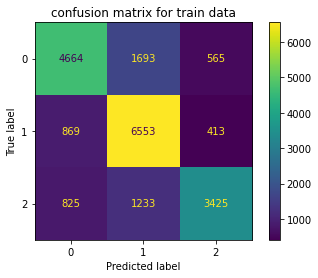

In [280]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(label_train_gl.cpu(), prob_train_gl.cpu())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for train data')

plt.show()

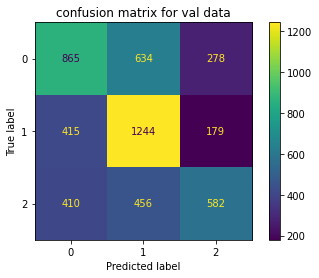

In [282]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(label_val_gl.cpu(), prob_val_gl.cpu())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for val data')

plt.show()

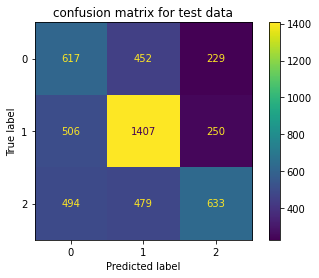

In [283]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(label_test_gl.cpu(), prob_test_gl.cpu())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for test data')

plt.show()

now we try BERT model as our language model:

In [17]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [284]:
with open('/content/MSCTD/MSCTD_data/ende/english_train.txt') as tr:
    text_train = [line.rstrip('\n') for line in tr]

with open('/content/MSCTD/MSCTD_data/ende/english_dev.txt') as v:
    text_val = [line.rstrip('\n') for line in v]

with open('/content/MSCTD/MSCTD_data/ende/english_test.txt') as te:
    text_test = [line.rstrip('\n') for line in te]

In [285]:
print(f'all possible punctuations = {string.punctuation}')
punc_remove = string.punctuation

all possible punctuations = !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [286]:
remove_translate = str.maketrans('', '', string.punctuation)

In [287]:
from transformers import BertConfig, BertTokenizer,BertModel

labels = ["neutral","negative","positive"]
label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')
MODEL_NAME_OR_PATH = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

label2id: {'neutral': 0, 'negative': 1, 'positive': 2}
id2label: {0: 'neutral', 1: 'negative', 2: 'positive'}


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


{
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dim": 768,
  "dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dim": 3072,
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "neutral",
    "1": "negative",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 0,
    "positive": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "n_heads": 12,
  "n_layers": 6,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [288]:
from torch import nn
class Sentiment_Bert_classifier(nn.Module):

    def __init__(self, config,MODEL_NAME_OR_PATH,fine_tune):
        super(Sentiment_Bert_classifier, self).__init__()

        bert_model = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        if (fine_tune):
          self.bert = bert_model
        else:
          for param in bert_model.parameters():
            param.requires_grad = False
          self.bert = bert_model
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, token_type_ids=token_type_ids,return_dict=False)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [289]:
pt_model = Sentiment_Bert_classifier(config=config,MODEL_NAME_OR_PATH = 'distilbert-base-uncased',fine_tune = True )
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertModel: ['distilbert.transformer.layer.2.attention.out_lin.weight', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.4.sa_layer_norm.weight', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.1.ffn.lin1.bias', 'distilbert.transformer.layer.5.ffn.lin2.bias', 'distilbert.transformer.layer.5.ffn.lin1.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.2.attention.v_lin.weight', 'distilbert.transformer.layer.5.attention.v_lin.weight', 'distilbert.transformer.layer.3.attention.out_lin.bias', 'distilbert.transformer.layer.5.sa_layer_norm.weight', 'distilbert.transformer.layer.3.sa_layer_norm.bias', 'distilbert.transformer.layer.2.sa_layer_norm.bias', 'distilbert

pt_model <class '__main__.Sentiment_Bert_classifier'>


we load the model from previous phase:

In [290]:
pt_model= pt_model.to(device)
if device == 'cpu':
  pt_model.load_state_dict(torch.load('/content/gdrive/MyDrive/phase3/bert_model/pt_model_trained_with_normal_text.pth',map_location=torch.device('cpu')))
else:
  pt_model.load_state_dict(torch.load('/content/gdrive/MyDrive/phase3/bert_model/pt_model_trained_with_normal_text.pth'))
pt_model.eval()

Sentiment_Bert_classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

now we load the labels:

In [291]:
with open('/content/MSCTD/MSCTD_data/ende/sentiment_train.txt') as f:
  sentiment_train = [int(line.rstrip('\n')) for line in f]
with open('/content/MSCTD/MSCTD_data/ende/sentiment_dev.txt') as f:
  sentiment_dev = [int(line.rstrip('\n')) for line in f]
with open('/content/MSCTD/MSCTD_data/ende/sentiment_test.txt') as f:
  sentiment_test = [int(line.rstrip('\n')) for line in f]

In [292]:
class sentiment_dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, text ,labels, max_len=128):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        text= str(self.text[item])

       
        target = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            
        }

       
        inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs

In [293]:
from transformers import AutoConfig , AutoTokenizer , AutoModel
config = AutoConfig.from_pretrained('distilbert-base-uncased')

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

model = AutoModel.from_pretrained('distilbert-base-uncased')





tokenizer.tokenize(text_train[34])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['she',
 'likes',
 'cooking',
 'italian',
 'because',
 'according',
 'to',
 'her',
 ',']

In [294]:
X = text_train
len_max = 0;
for i in range(len(X)):
  x_temp = X[i].split()
  if len(x_temp)>len_max:
    len_max = len(x_temp)
print(f"maximum length = {len_max}")
# now tokenizing based of max length we find
encoding = tokenizer.encode_plus(
    X[32],
    max_length=len_max+2,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

maximum length = 19
Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[  101, 15624,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [295]:
Dataset_Train = sentiment_dataset(tokenizer=tokenizer,text = text_train,labels = sentiment_train)

Dataset_Test = sentiment_dataset(tokenizer=tokenizer,text = text_test,labels = sentiment_test)

Dataset_Val = sentiment_dataset(tokenizer=tokenizer,text = text_val,labels = sentiment_dev)

In [296]:
#Creating Batch
from torch.utils.data import DataLoader
train_data_loader= DataLoader(Dataset_Train,batch_size=16,shuffle = False)
test_data_loader= DataLoader(Dataset_Test,batch_size=16,shuffle = False)
valid_data_loader= DataLoader(Dataset_Val,batch_size=16,shuffle = False)

In [297]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['text'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])

dict_keys(['text', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
["Okay. I'm confused.", "You don't care if I go to Paris with Jane,", "I'm sorry. I have to tell you something,", 'I have to go.', "I'm an accessory to murder.", "I think you've helped enough.", "Gaby, please. I can't stand this anymore.", "Can't we talk for a minute?", 'To be honest,', 'Wait. What do you mean?', 'He called us down to the station and grilled US one by one.', "Why didn't he call me down there?", 'Good question, given this whole thing is about you.', 'What are you talking about?', 'Bree, he wants revenge. He wants to bring you down,', 'Gaby, please.']
torch.Size([16, 128])
tensor([ 101, 3100, 1012, 1045, 1005, 1049, 5457, 1012,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

now we evaluate the loaded model:

train:

In [300]:
pt_model.eval()
targets_train = []
targets_predicted_train = []
prob_train_bert=torch.tensor([]).to(device)
with torch.inference_mode():
  for dl in tqdm(train_data_loader, total=len(train_data_loader), desc="training... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    prob_train_bert=torch.cat((prob_train_bert,outputs))
    preds = preds.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    targets_predicted_train.append(preds)
    targets_train.append(targets)

training... : 100%|██████████| 1265/1265 [02:52<00:00,  7.32it/s]


validation:

In [299]:
pt_model.eval()
targets_val = []
targets_predicted_val= []
prob_val_bert=torch.tensor([]).to(device)
with torch.inference_mode():
  for dl in tqdm(valid_data_loader, total=len(valid_data_loader), desc="Validating... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    prob_val_bert=torch.cat((prob_val_bert,outputs))
    preds = preds.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    targets_predicted_val.append(preds)
    targets_val.append(targets)


Validating... : 100%|██████████| 317/317 [00:44<00:00,  7.19it/s]


test:

In [301]:
pt_model.eval()
targets_test = []
targets_predicted_test = []
prob_test_bert=torch.tensor([]).to(device)
with torch.inference_mode():
  for dl in tqdm(test_data_loader, total=len(test_data_loader), desc="testing... "):
  # 1. Forward pass
    input_ids = dl['input_ids']
    attention_mask = dl['attention_mask']
    token_type_ids = dl['token_type_ids']
    targets = dl['targets']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    token_type_ids = token_type_ids.to(device)
    targets = targets.to(device)
    outputs = pt_model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids) # model outputs raw logits 
    _, preds = torch.max(outputs, 1)
    prob_test_bert=torch.cat((prob_test_bert,outputs))
    preds = preds.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    targets_predicted_test.append(preds)
    targets_test.append(targets)

testing... : 100%|██████████| 317/317 [00:41<00:00,  7.58it/s]


In [302]:
targets_predicted_train= np.concatenate(targets_predicted_train,axis = 0)
targets_train = np.concatenate(targets_train,axis = 0)

In [303]:
targets_predicted_val = np.concatenate(targets_predicted_val,axis = 0)
targets_val = np.concatenate(targets_val,axis = 0)

In [304]:
targets_predicted_test = np.concatenate(targets_predicted_test,axis = 0)
targets_test = np.concatenate(targets_test,axis = 0)

In [305]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


from sklearn import metrics

accuracy score on train data: 0.7079545454545455
f1 score on train data: 0.7069441114518503
precision score on train data: 0.7057446282791796
recall score on train data: 0.7116829375653594


Text(0.5, 1.0, 'confusion matrix for train data')

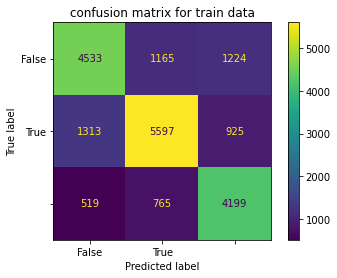

In [306]:
acc_test = accuracy_score(targets_train,targets_predicted_train)
f1_test = f1_score(targets_train, targets_predicted_train, average="macro")
pre_test = precision_score(targets_train, targets_predicted_train, average="macro")
recall_test = recall_score(targets_train, targets_predicted_train, average="macro")
print(f"accuracy score on train data: {acc_test}")
print(f"f1 score on train data: {f1_test}")
print(f"precision score on train data: {pre_test}")
print(f"recall score on train data: {recall_test}")
confusion_matrix = metrics.confusion_matrix(targets_train, targets_predicted_train)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.title('confusion matrix for train data')

accuracy score on validation data: 0.5234050957930081
f1 score on validation data: 0.5220989725981453
precision score on validation data: 0.5216803796866721
recall score on validation data: 0.5233160107740867


Text(0.5, 1.0, 'confusion matrix for val data')

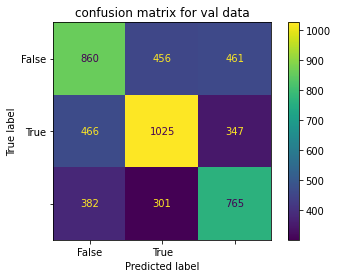

In [307]:
acc_test = accuracy_score(targets_val,targets_predicted_val)
f1_test = f1_score(targets_val, targets_predicted_val, average="macro")
pre_test = precision_score(targets_val, targets_predicted_val, average="macro")
recall_test = recall_score(targets_val, targets_predicted_val, average="macro")
print(f"accuracy score on validation data: {acc_test}")
print(f"f1 score on validation data: {f1_test}")
print(f"precision score on validation data: {pre_test}")
print(f"recall score on validation data: {recall_test}")
confusion_matrix = metrics.confusion_matrix(targets_val, targets_predicted_val)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.title('confusion matrix for val data')

accuracy score on test data: 0.5123347148213934
f1 score on test data: 0.5047362258777134
precision score on test data: 0.5091172776319263
recall score on test data: 0.5084298098887129


Text(0.5, 1.0, 'confusion matrix for test data')

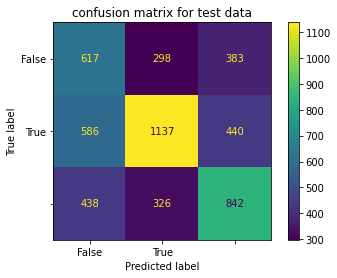

In [308]:
acc_test = accuracy_score(targets_test,targets_predicted_test)
f1_test = f1_score(targets_test, targets_predicted_test, average="macro")
pre_test = precision_score(targets_test, targets_predicted_test, average="macro")
recall_test = recall_score(targets_test, targets_predicted_test, average="macro")
print(f"accuracy score on test data: {acc_test}")
print(f"f1 score on test data: {f1_test}")
print(f"precision score on test data: {pre_test}")
print(f"recall score on test data: {recall_test}")
confusion_matrix = metrics.confusion_matrix(targets_test, targets_predicted_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.title('confusion matrix for test data')

now we combine the BERT model 

In [312]:
combined=torch.zeros(len(inp),8*3+1)
counter = 0
for i in tqdm(range(len(inp)), total = len(inp), desc="extracting ... "):
  combined[i,:-3]=inp[i]# loading file
  combined[i,-4:-1]=torch.from_numpy(np.array(prob_train_bert[i].cpu()))

extracting ... : 100%|██████████| 20240/20240 [00:04<00:00, 4747.60it/s]


In [313]:
combined_v=torch.zeros(len(inp_v),8*3+1)
counter = 0
for i in tqdm(range(len(inp_v)), total = len(inp_v), desc="extracting... "):
  combined_v[i,:-3]=inp_v[i]# loading file
  combined_v[i,-4:-1]=torch.from_numpy(np.array(prob_val_bert[i].cpu()))

extracting... : 100%|██████████| 5063/5063 [00:01<00:00, 4387.28it/s]


In [314]:
combined_t=torch.zeros(len(inp_t),8*3+1)
counter = 0
for i in tqdm(range(len(inp_t)), total = len(inp_t), desc="extracting ... "):
  combined_t[i,:-3]=inp_t[i]# loading file
  combined_t[i,-4:-1]=torch.from_numpy(np.array(prob_test_bert[i].cpu()))

extracting ... : 100%|██████████| 5067/5067 [00:01<00:00, 4951.64it/s]


again we use SVM for our model:

In [315]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
rbf3 = svm.SVC(kernel='rbf', gamma=0.5, C=50).fit(combined,sentiment_train)
predbert_train= rbf3.predict(combined)
acc = np.sum(predbert_train == sentiment_train)/len(predbert_train)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.7905632411067194


In [316]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#rbf2 = svm.SVC(kernel='rbf', gamma=0.5, C=10).fit(combined,sentiment_train)
predbert_val= rbf3.predict(combined_v)
acc = np.sum(predbert_val == sentiment_dev)/len(predbert_val)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.5192573572980447


In [317]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#rbf2 = svm.SVC(kernel='rbf', gamma=0.5, C=10).fit(combined,sentiment_train)
predbert_test= rbf3.predict(combined_t)
acc = np.sum(predbert_test == sentiment_test)/len(predbert_test)
print(f"svm based model accuracy = {acc}")

svm based model accuracy = 0.5162818235642392


now we train a MLP

In [318]:
batch_size = 64
train_datasetbert= comb_Dataset(inp=combined,labels=sentiment_train)
train_loaderbert= DataLoader(train_datasetbert,batch_size=batch_size,shuffle = True)

In [319]:
batch_size = 64
val_datasetbert= comb_Dataset(inp=combined_v,labels=sentiment_dev)
val_loaderbert= DataLoader(val_datasetbert,batch_size=batch_size,shuffle = True)

In [320]:
batch_size = 64
test_datasetbert= comb_Dataset(inp=combined_t,labels=sentiment_test)
test_loaderbert= DataLoader(test_datasetbert,batch_size=batch_size,shuffle = True)

In [321]:
import torch.nn as nn
import torch.nn.functional as F


class Net3(nn.Module):
  def __init__(self):
    super(Net3, self).__init__()
    self.layers=nn.Sequential(
        nn.Linear(3*(6+1+1)+1,64),
        nn.ReLU(),
        nn.Linear(64,16),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(16,8),
        nn.ReLU(),
        nn.Linear(8,3)
    )
  def forward(self, x):
    return self.layers(x)


net3 = Net3()

In [72]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer= optim.Adam(net3.parameters(), lr=0.001)
# Decay LR by a factor of 0.5 every 20 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

net3 = net3.to(device)
model_bert_trained,best_lossbert,best_accbert = train_model_manual(net3, criterion, optimizer,exp_lr_scheduler,20,train_loaderbert,val_loaderbert,len(train_loaderbert),len(val_loaderbert),num_epochs=100)

Validating... : 100%|██████████| 80/80 [00:00<00:00, 1389.23it/s]


Epoch: 0 | Loss: 1.33186, Acc: 66.16% | Test Loss: 0.02097, Test Acc: 52.42%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1485.04it/s]


Epoch: 1 | Loss: 1.13581, Acc: 70.78% | Test Loss: 0.01552, Test Acc: 52.66%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1369.36it/s]


Epoch: 2 | Loss: 1.12399, Acc: 71.13% | Test Loss: 0.02542, Test Acc: 52.66%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1546.94it/s]


Epoch: 3 | Loss: 1.11373, Acc: 71.15% | Test Loss: 0.02064, Test Acc: 53.05%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1485.87it/s]


Epoch: 4 | Loss: 1.11516, Acc: 71.14% | Test Loss: 0.01394, Test Acc: 52.68%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1569.13it/s]


Epoch: 5 | Loss: 1.11393, Acc: 71.14% | Test Loss: 0.02773, Test Acc: 52.89%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1495.90it/s]


Epoch: 6 | Loss: 1.11251, Acc: 70.96% | Test Loss: 0.01447, Test Acc: 52.78%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1038.74it/s]


Epoch: 7 | Loss: 1.10242, Acc: 71.20% | Test Loss: 0.00956, Test Acc: 52.81%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1025.35it/s]


Epoch: 8 | Loss: 1.10090, Acc: 71.13% | Test Loss: 0.03858, Test Acc: 52.81%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1058.71it/s]


Epoch: 9 | Loss: 1.10462, Acc: 71.35% | Test Loss: 0.00733, Test Acc: 52.81%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 742.24it/s]


Epoch: 10 | Loss: 1.10231, Acc: 71.15% | Test Loss: 0.02290, Test Acc: 52.99%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 883.57it/s]


Epoch: 11 | Loss: 1.09816, Acc: 71.42% | Test Loss: 0.01614, Test Acc: 53.21%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 755.92it/s]


Epoch: 12 | Loss: 1.09240, Acc: 71.60% | Test Loss: 0.02938, Test Acc: 52.87%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 910.33it/s]


Epoch: 13 | Loss: 1.09217, Acc: 71.39% | Test Loss: 0.01727, Test Acc: 52.87%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 952.44it/s]


Epoch: 14 | Loss: 1.09465, Acc: 71.36% | Test Loss: 0.01985, Test Acc: 52.72%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1363.61it/s]


Epoch: 15 | Loss: 1.08961, Acc: 71.30% | Test Loss: 0.02885, Test Acc: 52.91%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1497.89it/s]


Epoch: 16 | Loss: 1.09115, Acc: 71.62% | Test Loss: 0.00688, Test Acc: 52.97%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1486.08it/s]


Epoch: 17 | Loss: 1.09317, Acc: 71.31% | Test Loss: 0.02548, Test Acc: 52.66%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1371.72it/s]


Epoch: 18 | Loss: 1.09129, Acc: 71.20% | Test Loss: 0.01591, Test Acc: 52.79%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1445.90it/s]


Epoch: 19 | Loss: 1.08473, Acc: 71.50% | Test Loss: 0.01940, Test Acc: 52.87%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 849.58it/s]


Epoch: 20 | Loss: 1.08554, Acc: 71.42% | Test Loss: 0.01069, Test Acc: 52.76%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 991.50it/s]


Epoch: 21 | Loss: 1.08805, Acc: 71.43% | Test Loss: 0.01705, Test Acc: 52.64%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 510.70it/s]


Epoch: 22 | Loss: 1.08661, Acc: 71.42% | Test Loss: 0.01611, Test Acc: 52.91%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 462.41it/s]


Epoch: 23 | Loss: 1.08120, Acc: 71.56% | Test Loss: 0.01717, Test Acc: 52.99%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 622.04it/s]


Epoch: 24 | Loss: 1.08608, Acc: 71.71% | Test Loss: 0.02088, Test Acc: 52.89%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 898.78it/s]


Epoch: 25 | Loss: 1.08488, Acc: 71.58% | Test Loss: 0.02318, Test Acc: 52.91%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1501.42it/s]


Epoch: 26 | Loss: 1.07838, Acc: 71.77% | Test Loss: 0.01889, Test Acc: 52.85%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1600.02it/s]


Epoch: 27 | Loss: 1.08062, Acc: 71.61% | Test Loss: 0.02401, Test Acc: 52.91%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1540.41it/s]


Epoch: 28 | Loss: 1.08088, Acc: 71.48% | Test Loss: 0.01679, Test Acc: 52.72%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1489.71it/s]


Epoch: 29 | Loss: 1.08018, Acc: 71.50% | Test Loss: 0.02459, Test Acc: 52.64%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1573.07it/s]


Epoch: 30 | Loss: 1.07907, Acc: 71.71% | Test Loss: 0.02344, Test Acc: 52.70%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1375.48it/s]


Epoch: 31 | Loss: 1.08224, Acc: 71.55% | Test Loss: 0.02126, Test Acc: 52.78%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1378.63it/s]


Epoch: 32 | Loss: 1.07711, Acc: 71.81% | Test Loss: 0.03234, Test Acc: 52.81%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 868.42it/s]


Epoch: 33 | Loss: 1.08003, Acc: 71.50% | Test Loss: 0.01631, Test Acc: 52.60%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 1028.57it/s]


Epoch: 34 | Loss: 1.07617, Acc: 71.46% | Test Loss: 0.01505, Test Acc: 52.64%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 478.18it/s]


Epoch: 35 | Loss: 1.07410, Acc: 71.67% | Test Loss: 0.02442, Test Acc: 52.62%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 436.72it/s]


Epoch: 36 | Loss: 1.07431, Acc: 71.76% | Test Loss: 0.01399, Test Acc: 52.68%


Validating... : 100%|██████████| 80/80 [00:00<00:00, 439.51it/s]

early stopping happend!
Training complete in 0m 46s
Best val Acc: 53.209560


In [322]:
model_bert_trained.eval()
acc_test = 0
prob_train=torch.tensor([]).to(device)
label_train=torch.tensor([]).to(device)
with torch.inference_mode():
  for batch,label in tqdm(train_loaderbert, total=len(train_loaderbert), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_bert_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    prob_train=torch.cat((prob_train,preds))
    label_train=torch.cat((label_train,label))
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on train data = {acc_test/len(train_datasetbert)}')

Testing... : 100%|██████████| 317/317 [00:00<00:00, 1195.48it/s]



accuracy on train data = 0.7244564890861511


In [323]:
model_bert_trained.eval()
acc_test = 0
prob_val=torch.tensor([]).to(device)
label_val=torch.tensor([]).to(device)
with torch.inference_mode():
  for batch,label in tqdm(val_loaderbert, total=len(val_loaderbert), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_bert_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    prob_val=torch.cat((prob_val,preds))
    label_val=torch.cat((label_val,label))
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on val data = {acc_test/len(val_datasetbert)}')

Testing... : 100%|██████████| 80/80 [00:00<00:00, 854.70it/s]



accuracy on val data = 0.5320956110954285


In [324]:
model_bert_trained.eval()
acc_test = 0
prob_test=torch.tensor([]).to(device)
label_test=torch.tensor([]).to(device)
with torch.inference_mode():
  for batch,label in tqdm(test_loaderbert, total=len(test_loaderbert), desc="Testing... "):
  # 1. Forward pass
    batch = batch.to(device)
    label = label.to(device)
    output = model_bert_trained(batch) # model outputs raw logits 
    _, preds = torch.max(output, 1)
    prob_test=torch.cat((prob_test,preds))
    label_test=torch.cat((label_test,label))
    acc_test += torch.sum(preds == label.data)
print("\n")
print(f'accuracy on test data = {acc_test/len(test_datasetbert)}')

Testing... : 100%|██████████| 80/80 [00:00<00:00, 232.61it/s]



accuracy on test data = 0.5245707631111145


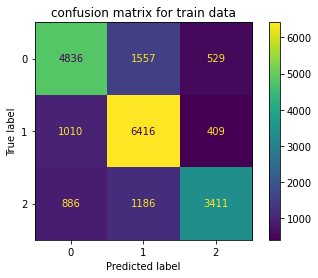

In [325]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(label_train.cpu(), prob_train.cpu())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for train data')

plt.show()

In [326]:

acc_test = accuracy_score(label_train.cpu(),prob_train.cpu())
f1_test = f1_score(label_train.cpu(), prob_train.cpu(), average="macro")
pre_test = precision_score(label_train.cpu(), prob_train.cpu(), average="macro")
recall_test = recall_score(label_train.cpu(), prob_train.cpu(), average="macro")
print(f"accuracy score on train data: {acc_test}")
print(f"f1 score on train data: {f1_test}")
print(f"precision score on train data: {pre_test}")
print(f"recall score on train data: {recall_test}")

accuracy score on train data: 0.7244565217391304
f1 score on train data: 0.7191035584463048
precision score on train data: 0.7343971539453918
recall score on train data: 0.7132120987174652


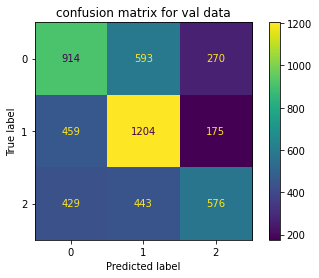

In [327]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(label_val.cpu(), prob_val.cpu())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for val data')

plt.show()

In [328]:

acc_test = accuracy_score(label_val.cpu(),prob_val.cpu())
f1_test = f1_score(label_val.cpu(),prob_val.cpu(), average="macro")
pre_test = precision_score(label_val.cpu(),prob_val.cpu(), average="macro")
recall_test = recall_score(label_val.cpu(),prob_val.cpu(), average="macro")
print(f"accuracy score on val data: {acc_test}")
print(f"f1 score on val data: {f1_test}")
print(f"precision score on val data: {pre_test}")
print(f"recall score on val data: {recall_test}")

accuracy score on val data: 0.532095595496741
f1 score on val data: 0.5226094630273825
precision score on val data: 0.5362889992727636
recall score on val data: 0.5223999770154765


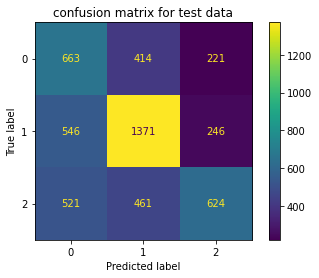

In [329]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(label_test.cpu(), prob_test.cpu())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['0', '1','2'])
cm_display.plot()
plt.title('confusion matrix for test data')

plt.show()

In [330]:

acc_test = accuracy_score(label_test.cpu(), prob_test.cpu())
f1_test = f1_score(label_test.cpu(), prob_test.cpu(), average="macro")
pre_test = precision_score(label_test.cpu(), prob_test.cpu(), average="macro")
recall_test = recall_score(label_test.cpu(), prob_test.cpu(), average="macro")
print(f"accuracy score on test data: {acc_test}")
print(f"f1 score on test data: {f1_test}")
print(f"precision score on test data: {pre_test}")
print(f"recall score on test data: {recall_test}")

accuracy score on test data: 0.5245707519242155
f1 score on test data: 0.5075196391948595
precision score on test data: 0.5218692844471469
recall score on test data: 0.5110568914998822


In [331]:
torch.save(model_bert_trained.state_dict(), '/content/gdrive/MyDrive/phase3/bert_model/best/model_bert_trained.pth')